## Example: kPCA and clustering for 2d and sequence data

Next, we'll illustrate how to run kPCA and kernel k-means clustering
using xGPR. We'll look at a simple 2d dataset first to build some intuitions,
then use some unaligned sequence data (sequences not part of an alignment
that are of many different lengths) to do some clustering. Note that to
run this demo, you'll need to download the github repo, since it includes
the test data (not included with the source distribution) and uses
the location of this notebook in the repo to find the test data.
As you'll see, clustering and visualizing data using random features is tricky
and has some possible pitfalls -- choosing hyperparameter values can be hard --
but the results can be interesting.

In [1]:
import os
import numpy as np
import xGPR
import matplotlib.pyplot as plt
import seaborn as sns
from xGPR import KernelxPCA, KernelFGen, build_online_dataset
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans

if "test_data" not in os.getcwd():
    os.chdir(os.path.join("..", "..", "test_data"))

We'll start off with a simple classic -- the circles dataset. We know because we generated
it the data contains two clusters. We also know we can recover two clusters using hierarchical
clustering. Can we do so using (kernel) k-means?

Text(0, 0.5, 'Arbitrary units')

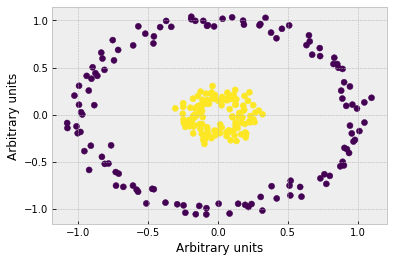

In [2]:
cx, cy = make_circles(n_samples=250, shuffle=True, noise=0.05, random_state=123, factor=0.2)

plt.style.use("bmh")
plt.scatter(cx[:,0], cx[:,1], c=cy)
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

We already know k-means which assumes spherical clusters will perform poorly here, but just for fun...

Text(0, 0.5, 'Arbitrary units')

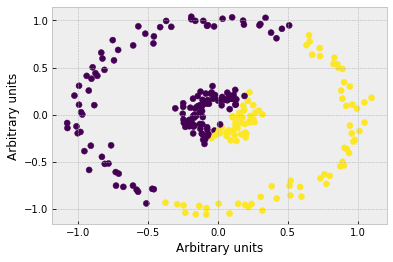

In [3]:
km = KMeans(n_clusters=2, random_state=123, n_init=5).fit(cx)

plt.style.use("bmh")
plt.scatter(cx[:,0], cx[:,1], c=km.labels_)
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

Very bad, as expected. We can do much better using kernel k-means, *but* as we'll see, the results
depend on our settings and *the hyperparameter that we use*. Notice that when constructing a dataset, xGPR
requires y-labels -- if we're using xGPR for clustering, we can just pass zeros or arbitrary
values when constructing this dataset. (This will be updated in a future version.) In this
case, it also doesn't make much sense to do kernel PCA, but just for fun we'll see what this would look
like.

Text(0, 0.5, 'Arbitrary units')

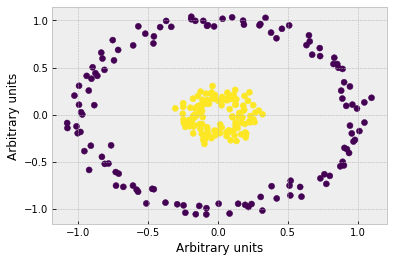

In [4]:
dataset = build_online_dataset(cx, np.zeros((cy.shape[0])), chunk_size=500)
kfgen = KernelFGen(num_rffs=1024, dataset=dataset, kernel_choice="RBF",
                   random_seed=123, hyperparams=np.array([1]),
                  kernel_specific_params={"intercept":False})

features = kfgen.predict(cx)
km = KMeans(n_clusters=2, random_state=123, n_init=5).fit(features)

plt.style.use("bmh")
plt.scatter(cx[:,0], cx[:,1], c=km.labels_)
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

And now for the kernel PCA...

Text(0, 0.5, 'Arbitrary units')

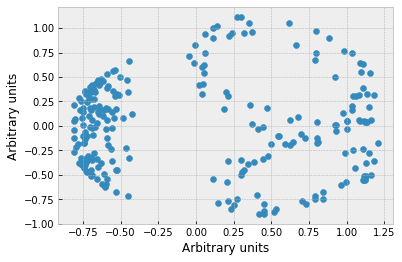

In [5]:
kxpca = KernelxPCA(num_rffs=512, n_components=2, dataset=dataset, kernel_choice="RBF",
                   random_seed=123, hyperparams=np.array([1]),
                  kernel_specific_params={"intercept":False})

features = kxpca.predict(cx)

plt.style.use("bmh")
plt.scatter(features[:,0], features[:,1])
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

This looks nice, but...and here's the tricky part -- if we use a non-optimal hyperparameter we
can easily make this much worse. Note that in xGPR, the kernel-specific hyperparameter for
RBF, Matern and all RBF-related kernels (e.g. FHTConv1d) is actually the *inverse* of the
lengthscale, and we are supplying the log of the hyperparameter, so a smaller or more negative
value actually means a longer lengthscale.

Text(0, 0.5, 'Arbitrary units')

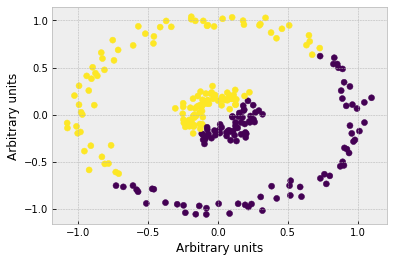

In [6]:
kfgen = KernelFGen(num_rffs=512, dataset=dataset, kernel_choice="RBF",
                   random_seed=123, hyperparams=np.array([-1.5]),
                  kernel_specific_params={"intercept":False})

features = kfgen.predict(cx)
km = KMeans(n_clusters=2, random_state=123, n_init=5).fit(features)

plt.style.use("bmh")
plt.scatter(cx[:,0], cx[:,1], c=km.labels_)
plt.xlabel("Arbitrary units")
plt.ylabel("Arbitrary units")

And now we're doing no better than K-means! The performance of the kernel k-means algorithm depends
on the choice of kernel and the choice of hyperparameter, which makes this fairly tricky. When fitting a
Gaussian process, we know which kernel and which hyperparameters we prefer -- the ones that
maximize the marginal likelihood or provide the best performance on a validation set. For clustering
and kPCA, there is no similar way to optimize the hyperparameter.

Let's look at a more interesting example -- a set of sequences.

There are 356 sequences


Text(0.5, 0, 'Sequence length')

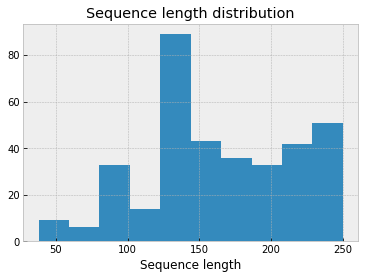

In [7]:
with open("cluster_seqs.txt", "r") as fhandle:
    raw_seqs = [l.strip() for l in fhandle]

print(f"There are {len(raw_seqs)} sequences")
    
_ = plt.hist([len(l) for l in raw_seqs])
plt.title("Sequence length distribution")
plt.xlabel("Sequence length")

These are very clearly not aligned. We can try to cluster and / or visualize them using the FHTConv1d
kernel in xGPR; this is equivalent to summing over (or averaging over, if we so choose) the pairwise
similarity of all k-mers of a preselected length in the sequences. First, we'll need to encode them.
We could zero-pad them to be the same length so that we can fit them all in one array then turn this
into an xGPR OnlineDataset, or we can group them by length, save each length batch in a numpy array file
on disk, then turn this list of files into an OfflineDataset. For illustrative purposes here,
we'll zero-pad. Note that when building the dataset, xGPR always requires you to supply y-values and
of course in this case we have none, so we'll just pass dummy values / zeros for now. We'll use a
convolution width of 9 in the kernel. Notice that -- because it runs convolutions -- the FHTConv1d
kernel is a little slower than the RBF kernel, so we'll use GPU rather than CPU here.

In [8]:
max_seqlen = max([len(l) for l in raw_seqs])

aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
           'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
aa_dict = {aa:i for i, aa in enumerate(aa_list)}

xdata = []
for seq in raw_seqs:
    padded_array = np.zeros((1, max_seqlen, 20))
    for i, letter in enumerate(seq):
        padded_array[0,i,aa_dict[letter]] = 1
    xdata.append(padded_array)

xdata = np.vstack(xdata)
xdataset = build_online_dataset(xdata, np.zeros((xdata.shape[0])), chunk_size=500)

As we will illustrate, the distribution of the data from kernel PCA and the resulting kernel
k-means clustering can vary significantly depending on the hyperparameter selection, although
in this case we do see a general trend. Also note that we have set 'averaging' to False, so
that k-mer similarities are summed rather than averaged. There may be cases where
'averaging':True makes more sense -- especially if we did not zero pad sequences.

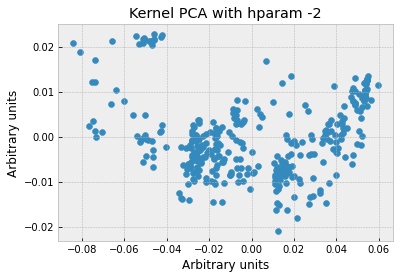

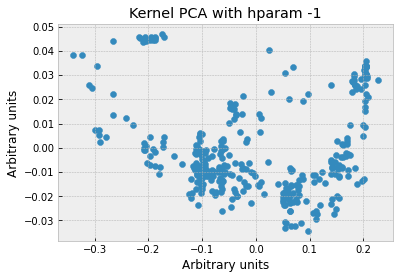

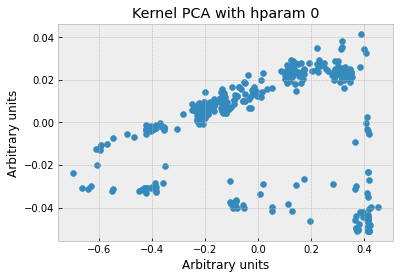

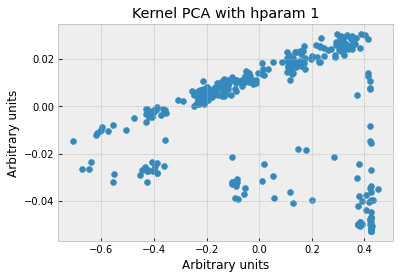

In [9]:
for hparam in [-2,-1,0,1]:
    kxpca = KernelxPCA(num_rffs=1024, n_components=2, dataset=xdataset, kernel_choice="FHTConv1d",
                   random_seed=123, hyperparams=np.array([hparam]),
                  kernel_specific_params={"conv_width":9, 'averaging':True}, device="gpu")

    features = kxpca.predict(xdata)

    plt.style.use("bmh")
    plt.scatter(features[:,0], features[:,1])
    plt.xlabel("Arbitrary units")
    plt.ylabel("Arbitrary units")
    plt.title(f"Kernel PCA with hparam {hparam}")
    plt.show()

Now we'll try to find the optimal number of clusters for each hyperparameter setting...

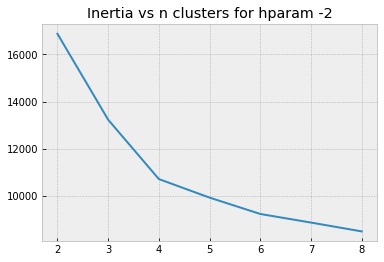

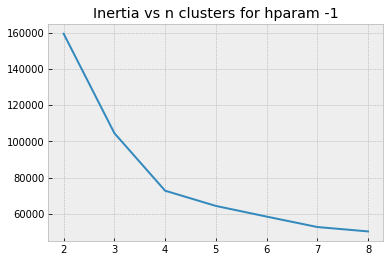

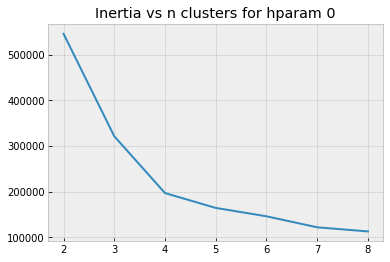

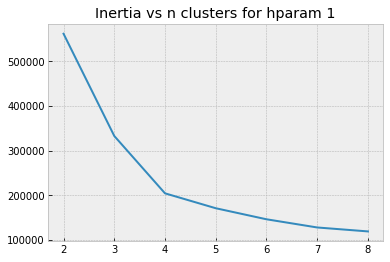

In [10]:

for hparam in [-2,-1,0,1]:
    kf = KernelFGen(num_rffs=1024, dataset=xdataset, kernel_choice="FHTConv1d",
                   random_seed=123, hyperparams=np.array([hparam]),
                  kernel_specific_params={"conv_width":9}, device="gpu")

    features = kf.predict(xdata)

    inertia_vals, nc = [], []
    for nclust in [2,3,4,5,6,7,8]:
        km = KMeans(n_clusters=nclust, random_state=123, n_init=5).fit(features)
        nc.append(nclust)
        inertia_vals.append(km.inertia_)
        
    sns.lineplot(x=nc, y=inertia_vals)
    plt.title(f"Inertia vs n clusters for hparam {hparam}")
    plt.show()

Interestingly, these (arguably) seem to be consistent with 4 clusters. If we use 4 clusters, which
hyperparameter value makes the most sense? We'll try to use a silhouette plot to decide.

[0.3041875182885503, 0.4251338434971252, 0.4974378813745789, 0.49354781924661806]


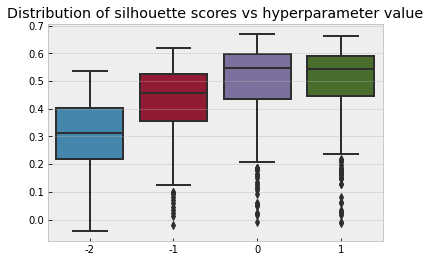

In [11]:
from sklearn.metrics import silhouette_samples, silhouette_score

avg_silhouette_values = []
all_silhouette_values = []
hparam_list = []

for hparam in [-2,-1,0,1]:
    kf = KernelFGen(num_rffs=1024, dataset=xdataset, kernel_choice="FHTConv1d",
                   random_seed=123, hyperparams=np.array([hparam]),
                  kernel_specific_params={"conv_width":9}, device="gpu")

    features = kf.predict(xdata)
    km = KMeans(n_clusters=4, random_state=123, n_init=5).fit(features)

    avg_silhouette_values.append(silhouette_score(features, km.labels_))
    all_silhouette_values += silhouette_samples(features, km.labels_).tolist()
    hparam_list += [hparam for i in range(features.shape[0])]
    
sns.boxplot(x=hparam_list, y=all_silhouette_values)
plt.title("Distribution of silhouette scores vs hyperparameter value")
print(avg_silhouette_values)

This gives us at least some reason to think hparam 0 or 1 might be better settings, and that 4 clusters is
preferable. It's extremely important when clustering however to do sanity checks. We might in this case
for example cluster these sequences using another algorithm, e.g. using alignment distance (slow to
calculate but very bulletproof). Or, in this particular case, since these sequences can be built into
a multiple sequence alignment, we could construct this alignment then cluster them using a simpler
algorithm (see https://github.com/jlparkI/categorical_mixture for an example). Or we could take an in-depth
look at sequences assigned to each cluster. For now, since this is merely a
demo, we'll content ourselves with inspecting a few properties of the resulting clusters.

<AxesSubplot:title={'center':'Length of sequence in each cluster'}>

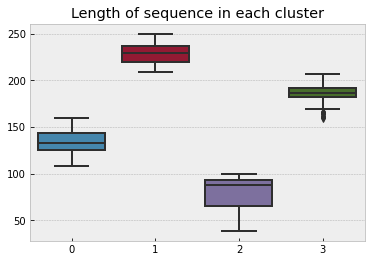

In [12]:
len_distro, cvalues = [], []
for i in range(4):
    c_distro = [len(l) for j, l in enumerate(raw_seqs) if km.labels_[j] == i]
    cvalues += [i for j in c_distro]
    len_distro += c_distro
    
plt.title("Length of sequence in each cluster")
sns.boxplot(x=cvalues, y=len_distro)

We see that the length of typical sequences in each cluster is quite different. Since this is just
a demo, we'll leave it here although there's obviously a lot more we could (and in a real application should)
do. Hopefully this illustrates some key attributes of clustering and visualizing with random features.
As you can see, clustering with random features is tricky -- there are hyperparameters that can change the
results and many possible pitfalls -- but hopefully this also illustrates there are some interesting things
you can potentially do.